In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [2]:
datafolder = ''

In [3]:
experiment = 'Eoi400' 
model = 'HadCM3'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/E280_2900-2999_Annual.nc')
    dsr = xr.open_dataset(folder+'/Region_file.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/E280_avg_Atlantic_MOC.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/E280_heat_calculation.nc')
    dsice = xr.open_dataset(folder+experiment+'/E280_2900_2999_Monthly_iceconc.nc')
elif experiment == 'Eoi400':
    ds = xr.open_dataset(folder+experiment+'/Eoi400_2400-2499_Annual.nc')
    dsr = xr.open_dataset(folder+'/Region_file.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/Eoi400_avg_Atlantic_MOC.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/Eoi400_heat_calculation.nc')
    dsice = xr.open_dataset(folder+experiment+'/EOI400_2400_2499_Monthly_iceconc.nc')

## Separation MOC and gyre OHT component 100-yr average

In [5]:
vvel = ds.field704
temp = ds.temp_1_opf

#Atlantic Ocean region
regiont = dsr.region

In [6]:
#1-D array with spacing of depth grid
dz2 = np.zeros(len(ds.z2))
dz2[0] = ds.z2[0].values*2
depth = dz2[0]
for i in range(1,len(ds.z2)):
    dz2[i] = (ds.z2[i].values-depth)*2
    depth = depth+dz2[i]
dz2 = dz2*100 #Depth spacing. Units: cm
ds['dz2'] = xr.DataArray(data=dz2, dims=("z2"))
dz2 = ds.dz2

#2-D array with spacing of horizontal grid 
r = 6.37122e8 #radius Earth in cm
dlon2 = np.deg2rad(1.25)*r*np.cos(np.deg2rad(ds.lat1)) #Lon spacing. Units: cm. Interpolating to the T-grid

a = dlon2
dlon2 = np.zeros([len(ds.lat1),len(ds.lon2)])
for i in range(len(ds.lon2)):
    dlon2[:,i]=a.values
ds['dlon2']=xr.DataArray(data = dlon2, dims=("lat1","lon2"))
dlon2 = ds.dlon2

In [7]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

HEAT = (cp_sw*rho_sw*temp).where(regiont>2) #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

#Interpolate velocity to temperature grid (set land values to 0 first to avoid NaN ocean grid cells after interpolation)
vvel = vvel.fillna(0).interp(lat2 = ds.lat1, lon3 = ds.lon2, method='linear')
VVEL = vvel.where(regiont>2) #cm/s
VVEL = VVEL*HEAT/HEAT #Mask land with NaN values of the T grid

In [8]:
#Zonal mean velocity and heat
VVEL_zm = VVEL.mean(dim='lon2')
HEAT_zm = HEAT.mean(dim='lon2')

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm)  # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]


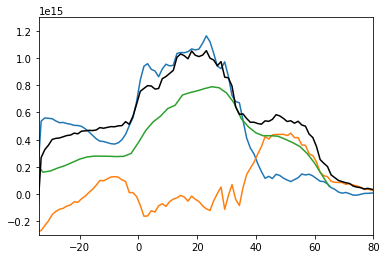

In [9]:
#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dlon2*dz2).sum(dim=['lon2','z2'])
Haz = (VVEL_prime*HEAT_prime*dlon2*dz2).sum(dim=['lon2','z2'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

plt.plot(ds.lat1, Hov)
plt.plot(ds.lat1, Haz)
if experiment == 'E280':
    plt.plot(dsOHT.lat,dsOHT.oht2[1]*10**15)
else:
    plt.plot(dsOHT.lat,dsOHT.oht1[1]*10**15)
plt.xlim([-34,80])
plt.ylim([-0.3e15, 1.3e15])

plt.plot(ds.lat1, Hov+Haz,color='black')

In [10]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov/1e15), OHTaz=(["lat"], Haz/1e15)), coords = dict(lat = ds.lat1.values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC

In [11]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), dsMOC.Merid_Atlantic[0,:,:].values)), coords = dict(z = dsMOC.depth.values, lat = dsMOC.latitude.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## 100-yr mean total Atlantic OHT

In [12]:
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (Hov+Haz)/1e15)), coords = dict(lat = ds.lat1.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

if experiment == 'E280':
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), dsOHT.oht2[1,:].values)), coords = dict(lat = dsOHT.lat.values))
else:
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), dsOHT.oht1[1,:].values)), coords = dict(lat = dsOHT.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr_impl.nc')

## Annual AMOC streamfunction (100 years)

In [13]:
#Every file contains yearly average AMOC streamfunction 
amoc = np.zeros([100,21,143])
if experiment == 'E280':
    for i in range(0,100):
        if i<10:
            ds = xr.open_dataset(folder+experiment+'/Time_seriesMOC/tenvoo@pgt0'+str(i)+'c1.nc')
        else:
            ds = xr.open_dataset(folder+experiment+'/Time_seriesMOC/tenvoo@pgt'+str(i)+'c1.nc')
        amoc[i,:,:] = ds.Merid_Atlantic[0,:,:].values
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(2900, 3000), z = ds.depth.values, lat = ds.latitude.values))
else:  
    for i in range(0,100):
        if i<10:
            ds = xr.open_dataset(folder+experiment+'/Time_seriesMOC/tenvjo@pgo0'+str(i)+'c1.nc')
        else:
            ds = xr.open_dataset(folder+experiment+'/Time_seriesMOC/tenvjo@pgo'+str(i)+'c1.nc')
        amoc[i,:,:] = ds.Merid_Atlantic[0,:,:].values
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(2400, 2500), z = ds.depth.values, lat = ds.latitude.values))

xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## Annual SST timeseries (100 years)

In [14]:
dstos = xr.open_dataset(folder+experiment+'/HadCM3_'+experiment+'.SST.timeseries_no_ann_cycle.nc')#, decode_times=False)
dsclim = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')

tosann = dstos.temp.groupby('time.year').mean(dim='time')+dsclim.temp.mean(dim='month')

if experiment == 'E280':
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann.values)), coords = dict(time = np.arange(2900, 3000), lat = tosann.latitude.values, lon = tosann.longitude.values))
else:
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann.values)), coords = dict(time = np.arange(2400, 2500), lat = tosann.latitude.values, lon = tosann.longitude.values))
    
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

## 100-yr SSS (regridded)

In [15]:
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/E280_2900-2999_Annual.nc')
elif experiment == 'Eoi400':
    ds = xr.open_dataset(folder+experiment+'/Eoi400_2400-2499_Annual.nc')

#Renaming lat and lon of salinity field to allow for interpolation 
dsS = ds.copy(deep=True)
dsS = dsS.drop(['lat2', 'lat3', 'lat4', 'lon1', 'lon3', 'lon4', 'z1', 'z3', 'z4'])
dsS = dsS.rename({'lat1': 'lat','lon2': 'lon'})

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.salinity[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr sea ice (regridded)

In [16]:
djf = (dsice.iceconc_opf[11]+dsice.iceconc_opf[0]+dsice.iceconc_opf[1])/3
mam = (dsice.iceconc_opf[2]+dsice.iceconc_opf[3]+dsice.iceconc_opf[4])/3
jja = (dsice.iceconc_opf[5]+dsice.iceconc_opf[6]+dsice.iceconc_opf[7])/3
son = (dsice.iceconc_opf[8]+dsice.iceconc_opf[9]+dsice.iceconc_opf[10])/3

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsice, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)*100
si_mam = regridder(mam)*100
si_jja = regridder(jja)*100
si_son = regridder(son)*100

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean top 100 m salinity

In [17]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("z2"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.z2[0:7])

s100m = regridder(dsS.salinity[0:7].weighted(weights).mean(dim='z2'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity

In [18]:
salt_atl = dsS.salinity

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.z2.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature

In [19]:
#Renaming lat and lon of temperature field to allow for interpolation 
dsT = ds.copy(deep=True)

temp_atl = dsT.temp_1_opf
temp_atl = temp_atl.rename({'lat1': 'lat','lon2': 'lon'})

dsT = dsT.drop(['lat2', 'lat3', 'lat4', 'lon1', 'lon3', 'lon4', 'z1', 'z3', 'z4'])
dsT = dsT.rename({'lat1': 'lat','lon2': 'lon'})

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.z2.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [20]:
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/E280_2900-2999_Annual.nc')
elif experiment == 'Eoi400':
    ds = xr.open_dataset(folder+experiment+'/Eoi400_2400-2499_Annual.nc')
    
ds = ds.drop(['lat1', 'lat2', 'lat4', 'lon1', 'lon3', 'lon2', 'z1', 'z3', 'z2'])
ds = ds.rename({'lat3': 'lat','lon4': 'lon'})

In [21]:
ua = ds.u[0]
va = ds.v[0]

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(ds, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
